## Assignment 3

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Task 1: ICE and PDP Plots

### Task 2: Create Training Data for Incomplete Journeys

In [2]:
df = pd.read_parquet("data/journeys_flattened.parquet")

In [3]:
start_timestamp = pd.Timestamp('2020-11-03 03:31:30+0000', tz='UTC')
end_timestamp = pd.Timestamp('2023-01-23 12:29:56+0000', tz='UTC')

In [4]:
outcomes = []
for row in df.itertuples(index=False):
    if 28 in row.events:
        outcomes.append('successful')
    elif (end_timestamp - pd.Timestamp(row.timestamps[-1], tz='UTC')) / np.timedelta64(1, 'D') > 60:
        outcomes.append('unsuccessful')
    else:
        outcomes.append('ongoing')

df['outcome'] = outcomes

In [5]:
first_timestamps = []
last_timestamps = []

for row in df.itertuples(index=False):
    first_timestamps.append(pd.Timestamp(row.timestamps[0], tz='UTC'))
    if row.outcome == 'successful':
        last_timestamps.append(pd.Timestamp(row.timestamps[np.where(row.events == 28)[0][0]], tz='UTC'))
    elif row.outcome == 'unsuccessful':
        last_timestamps.append(pd.Timestamp(row.timestamps[-1] + np.timedelta64(60, 'D'), tz='UTC'))
    else:
        last_timestamps.append(end_timestamp)

df['start_timestamp'] = first_timestamps
df['end_timestamp'] = last_timestamps

In [6]:
training_dataset = df[df['outcome'] != 'ongoing'].copy()
test_dataset = df[df['outcome'] == 'ongoing'].copy()

In [7]:
train_df, val_df = train_test_split(training_dataset, test_size=0.3, random_state=0)

In [8]:
np.random.seed(823)

# We have about 27 months worth of data and want a cutoff about once every 2 weeks (on average)
time_splits = start_timestamp + (end_timestamp - start_timestamp) * np.random.random(size=54)

sampled_journeys_train = []
sampled_journeys_val = []

# We want about 4.5 million journeys from our 54 time splits => want about 85,000 journeys per time split
for split in time_splits:
    ongoing_journeys_train = train_df[(train_df['start_timestamp'] < split) & (train_df['end_timestamp'] > split)]
    ongoing_journeys_train = ongoing_journeys_train.sample(n=min(ongoing_journeys_train.shape[0], 85000))
    ongoing_journeys_train['current_datetime'] = split
    sampled_journeys_train.append(ongoing_journeys_train)

    ongoing_journeys_val = val_df[(val_df['start_timestamp'] < split) & (val_df['end_timestamp'] > split)]
    ongoing_journeys_val = ongoing_journeys_val.sample(n=min(ongoing_journeys_val.shape[0], 45000))
    ongoing_journeys_val['current_datetime'] = split
    sampled_journeys_val.append(ongoing_journeys_val)

sampled_train_df = pd.concat(sampled_journeys_train, ignore_index=True)
sampled_val_df = pd.concat(sampled_journeys_val, ignore_index=False)

In [9]:
sampled_train_df.reset_index(drop=True, inplace=True)
sampled_val_df.reset_index(drop=True, inplace=True)

In [10]:
# Update columns in datasets so that they reflect the journey up until the cutoff time
def truncate_journeys(df):
    for i in range(len(df)):
        timestamps = df.at[i, 'timestamps']
        cutoff_time = df.at[i, 'current_datetime'].tz_localize(None)

        cutoff_index = np.searchsorted(timestamps, cutoff_time, side='right')

        df.at[i, 'timestamps'] = timestamps[:cutoff_index]
        df.at[i, 'events'] = df.at[i, 'events'][:cutoff_index]
        df.at[i, 'event_names'] = df.at[i, 'event_names'][:cutoff_index]
        df.at[i, 'journey_length'] = cutoff_index

truncate_journeys(sampled_train_df)
truncate_journeys(sampled_val_df)

In [11]:
# This gives us about 4 million journeys for training and 2 million for validation, which seems sufficient for now
print(f"There are {sampled_train_df.shape[0]} training journeys and {sampled_val_df.shape[0]} validation journeys")

There are 4005355 training journeys and 2039576 validation journeys


In [12]:
# Shuffle rows so that splits from the same journey are not grouped together
sampled_train_df = sampled_train_df.sample(frac=1, random_state=523).reset_index(drop=True)
sampled_val_df = sampled_val_df.sample(frac=1, random_state=784).reset_index(drop=True)

In [13]:
test_dataset['current_datetime'] = end_timestamp

In [14]:
def normalize_list_column(col):
    def normalize(x):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return []                 # empty list, not NaN
        if isinstance(x, np.ndarray):
            return x.tolist()
        if isinstance(x, list):
            return x
        return [x]                    # scalar → list
    return col.apply(normalize)

In [15]:
sampled_train_df['events'] = normalize_list_column(sampled_train_df['events'])
sampled_val_df['events']   = normalize_list_column(sampled_val_df['events'])
sampled_train_df['timestamps'] = normalize_list_column(sampled_train_df['timestamps'])
sampled_val_df['timestamps']   = normalize_list_column(sampled_val_df['timestamps'])
sampled_train_df['event_names'] = normalize_list_column(sampled_train_df['event_names'])
sampled_val_df['event_names']   = normalize_list_column(sampled_val_df['event_names'])

In [21]:
import numpy as np
import pandas as pd

def normalize_for_parquet(df: pd.DataFrame) -> pd.DataFrame:
    """
    Robustly standardizes list columns for Parquet.
    Handles None, NaNs, scalars, and crucially, converts numpy arrays to lists.
    """
    def robust_ensure_list(x):
        if x is None: 
            return []
        # Handle NaN (float)
        if isinstance(x, float) and np.isnan(x): 
            return []
        # FIX: Convert numpy array to list
        if isinstance(x, np.ndarray): 
            return x.tolist()
        # List stays list
        if isinstance(x, list): 
            return x
        # Scalar becomes list
        return [x]

    def clean_str_list(lst):
        # Convert all elements to strings to avoid PyArrow mixed-type errors
        return [str(x) for x in lst] if lst else []

    # 1. Normalize structure (ensure everything is a list)
    for col in ["events", "event_names", "timestamps"]:
        if col in df.columns:
            df[col] = df[col].apply(robust_ensure_list)

    # 2. Enforce string types for event_names (common source of Arrow errors)
    if "event_names" in df.columns:
        df["event_names"] = df["event_names"].apply(clean_str_list)
        
    # 3. Ensure events are compatible (optional, usually ints are fine in lists)
    # If you have mixed types in 'events', uncomment the line below:
    # if "events" in df.columns: df["events"] = df["events"].apply(clean_str_list)

    return df

# Apply the fix
sampled_train_df = normalize_for_parquet(sampled_train_df)
sampled_val_df   = normalize_for_parquet(sampled_val_df)
test_dataset     = normalize_for_parquet(test_dataset)

# Save
sampled_train_df.to_parquet("data/training_data.parquet", index=False)
sampled_val_df.to_parquet("data/validation_data.parquet", index=False)
test_dataset.to_parquet("data/testing_data.parquet", index=False)

print("✅ Data normalized and saved successfully.")

✅ Data normalized and saved successfully.


#### Feature Engineering

In [22]:
train_df = pd.read_parquet('data/training_data.parquet')
val_df = pd.read_parquet('data/validation_data.parquet')

In [23]:
# Important to notice that there is massive class imbalance!!
# We should use a metric like F1 score to evaluate our model rather than accuracy
train_df['outcome'].value_counts()

outcome
unsuccessful    3737880
successful       267475
Name: count, dtype: int64

In [24]:
# Number of days that the journey has been going for up until the cutoff
train_df['days_into_journey'] = [(current_datetime - first_datetime) / np.timedelta64(1, 'D') for current_datetime, first_datetime in zip(train_df['current_datetime'], train_df['start_timestamp'])]
val_df['days_into_journey'] = [(current_datetime - first_datetime) / np.timedelta64(1, 'D') for current_datetime, first_datetime in zip(val_df['current_datetime'], val_df['start_timestamp'])]

In [25]:
# Create indicator features for all events
for i in range(1, 30):
    if i not in (17, 25, 28):
        train_df[f"event{i}"] = [i in ev for ev in train_df["events"]]
        val_df[f"event{i}"] = [i in ev for ev in val_df["events"]]

In [27]:
import numpy as np
import pandas as pd

def compute_time_diff(ts, current_time):
    # 1. Handle bad data (None, NaN, not a list)
    if not isinstance(ts, list):
        return np.nan
    
    # 2. Handle empty lists
    if len(ts) == 0:
        return np.nan
    
    # 3. Get last timestamp
    last_ts = ts[-1]
    
    # 4. Convert string to Timestamp (if needed) & ensure timezone-naive
    if isinstance(last_ts, str):
        last_ts = pd.Timestamp(last_ts)
    
    # Ensure both are timezone-naive for subtraction
    if hasattr(last_ts, 'tz_localize'):
        last_ts = last_ts.tz_localize(None)
        
    return (current_time - last_ts) / np.timedelta64(1, 'D')

# Apply to Train
# Ensure current_datetime is tz-naive first to avoid repeated conversion in the loop
train_current_dates = train_df["current_datetime"].dt.tz_localize(None)
train_df["time_diff_days"] = [
    compute_time_diff(ts, cur) 
    for ts, cur in zip(train_df["timestamps"], train_current_dates)
]

# Apply to Validation
val_current_dates = val_df["current_datetime"].dt.tz_localize(None)
val_df["time_diff_days"] = [
    compute_time_diff(ts, cur) 
    for ts, cur in zip(val_df["timestamps"], val_current_dates)
]

In [30]:
import numpy as np
import pandas as pd

quantiles = [0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 1]
q_cols = [f"days_between_actions_q_{int(q*100)}" for q in quantiles]

def compute_row_quantiles(ts):
    # 1. Handle non-list, empty, or insufficient data
    if not isinstance(ts, list) or len(ts) < 2:
        return [np.nan] * len(quantiles)

    # 2. Convert to datetime objects (handles strings from Parquet)
    # errors='coerce' turns invalid strings into NaT (Not a Time)
    dt_index = pd.to_datetime(ts, errors='coerce', utc=True)
    
    # 3. Drop invalid NaT values (in case of parsing errors)
    dt_valid = dt_index.dropna()

    if len(dt_valid) < 2:
        return [np.nan] * len(quantiles)

    # 4. Calculate differences
    # np.diff works on datetime objects returning timedeltas
    diffs = np.diff(dt_valid.values)

    # 5. Convert timedeltas to float days
    diffs_days = diffs / np.timedelta64(1, 'D')
    
    return np.quantile(diffs_days, quantiles)

print("Computing quantiles for Training set...")
train_result = np.vstack([
    compute_row_quantiles(ts)
    for ts in train_df['timestamps']
])
train_df[q_cols] = train_result

print("Computing quantiles for Validation set...")
val_result = np.vstack([
    compute_row_quantiles(ts)
    for ts in val_df['timestamps']
])
val_df[q_cols] = val_result

print("✅ Quantiles computed successfully.")

Computing quantiles for Training set...
Computing quantiles for Validation set...
✅ Quantiles computed successfully.


In [31]:
# Include the first event as a feature
train_df['first_event'] = [events[0] for events in train_df['events']]
val_df['first_event'] = [events[0] for events in val_df['events']]

In [32]:
# Get the counts for events that occur more than once during journeys in the training dataset
repeatable_events = set()
for row in train_df.itertuples(index=False):
    repeatable_events.update([item for item, count in Counter(row.events).items() if count > 1])

train_event_counts = train_df['events'].apply(Counter)
train_counts_df = (
    pd.DataFrame(train_event_counts.tolist())
      .reindex(columns=repeatable_events)
      .fillna(0)
      .astype(int)
      .rename(columns=lambda e: f'event_{e}_count')
)

train_df = train_df.join(train_counts_df)

val_event_counts = val_df['events'].apply(Counter)
val_counts_df = (
    pd.DataFrame(val_event_counts.tolist())
      .reindex(columns=repeatable_events)
      .fillna(0)
      .astype(int)
      .rename(columns=lambda e: f'event_{e}_count')
)

val_df = val_df.join(val_counts_df)

In [33]:
# Add extra indicator about if this milestone was reached
milestone_to_events = {
    1: (12, 15),
    2: (7, 18),
    3: (29,),
    4: (8,),
    5: (27,)
}

for milestone, events in milestone_to_events.items():
    train_df[f'reached_milestone_{milestone}'] = [any([event in journey_events for event in events]) for journey_events in train_df['events']]
    val_df[f'reached_milestone_{milestone}'] = [any([event in journey_events for event in events]) for journey_events in val_df['events']]

In [34]:
# Add the number of days that it takes to reach each milestone in the journey (assuming that the milestone was actually achieved)
for milestone in range(1, 6):
    train_df[f'days_to_milestone_{milestone}'] = [(timestamps[np.where(np.isin(events, milestone_to_events[milestone]))[0][0]] - timestamps[0]) / np.timedelta64(1, 'D') if indicator else np.nan for timestamps, events, indicator in zip(train_df['timestamps'], train_df['events'], train_df[f'reached_milestone_{milestone}'])]
    val_df[f'days_to_milestone_{milestone}'] = [(timestamps[np.where(np.isin(events, milestone_to_events[milestone]))[0][0]] - timestamps[0]) / np.timedelta64(1, 'D') if indicator else np.nan for timestamps, events, indicator in zip(val_df['timestamps'], val_df['events'], val_df[f'reached_milestone_{milestone}'])]

In [35]:
train_df.to_parquet('data/training_data_features.parquet', index=False)
val_df.to_parquet('data/validation_data_features.parquet', index=False)

In [3]:
train_df = pd.read_parquet('data/training_data_features.parquet')
val_df = pd.read_parquet('data/validation_data_features.parquet')

In [4]:
X_train = train_df.drop(columns=['id', 'events', 'event_names', 'timestamps', 'outcome', 'start_timestamp', 'end_timestamp', 'current_datetime'])
y_train = (train_df["outcome"] == 'successful').astype('int')

X_val = val_df.drop(columns=['id', 'events', 'event_names', 'timestamps', 'outcome', 'start_timestamp', 'end_timestamp', 'current_datetime'])
y_val = (val_df["outcome"] == 'successful').astype('int')

### Task 3: Fit a Predictive Model

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
import joblib

# Initialize the model
# n_jobs=-1 uses all processors to speed up training
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15, 
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# --- Task 4: Cross Validation ---
print("Starting 5-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We use F1 score as the metric due to the class imbalance
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# --- Task 3: Fit Predictive Model (Final Training) ---
print("\nFitting model on full training set...")
rf_model.fit(X_train, y_train)

# Evaluate on the hold-out validation set (X_val) to confirm generalization
val_preds = rf_model.predict(X_val)
print("\nValidation Set Performance:")
print(classification_report(y_val, val_preds))

# Save the model
joblib.dump(rf_model, 'models/random_forest_model.joblib')
print("Model saved to 'models/random_forest_model.joblib'")

Starting 5-Fold Cross-Validation...
Cross-Validation F1 Scores: [0.25482084 0.25319844 0.25426837 0.25391343 0.25427291]
Mean F1 Score: 0.2541 (+/- 0.0011)

Fitting model on full training set...

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83   1906385
           1       0.15      0.67      0.24    133191

    accuracy                           0.73   2039576
   macro avg       0.56      0.70      0.54   2039576
weighted avg       0.92      0.73      0.80   2039576

Model saved to 'models/random_forest_model.joblib'


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
import joblib

# Initialize the model
# n_jobs=-1 uses all processors to speed up training
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15, 
    random_state=42,
    n_jobs=-1
)

# --- Task 4: Cross Validation ---
print("Starting 5-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We use F1 score as the metric due to the class imbalance
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Starting 5-Fold Cross-Validation...
Cross-Validation F1 Scores: [0.93763349 0.9377371  0.93757233 0.93772337 0.93756858]
Mean F1 Score: 0.9376 (+/- 0.0001)


In [7]:
print("\nFitting model on full training set...")
rf_model.fit(X_train, y_train)

# Evaluate on the hold-out validation set (X_val) to confirm generalization
val_preds = rf_model.predict(X_val)
print("\nValidation Set Performance:")
print(classification_report(y_val, val_preds))

# Save the model
joblib.dump(rf_model, 'models/random_forest_model_final.joblib')
print("Model saved to 'models/random_forest_model_final.joblib'")


Fitting model on full training set...

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1906385
           1       0.81      0.08      0.14    133191

    accuracy                           0.94   2039576
   macro avg       0.87      0.54      0.55   2039576
weighted avg       0.93      0.94      0.91   2039576

Model saved to 'models/random_forest_model_final.joblib'


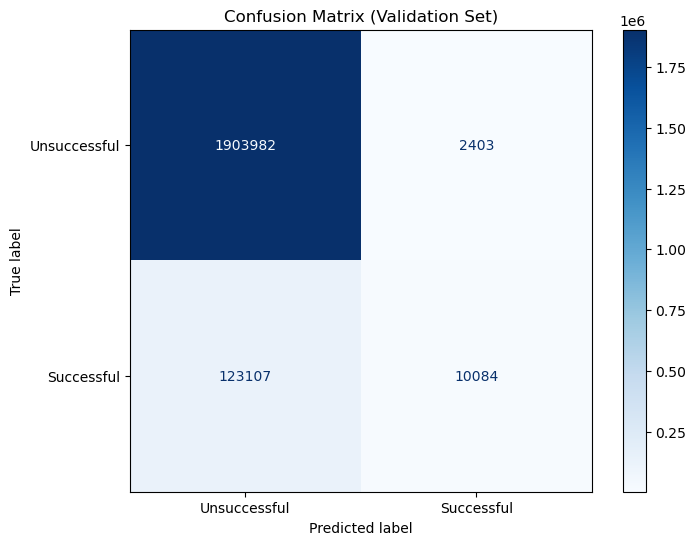

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val, val_preds)

# Create the display
# display_labels maps 0 -> Unsuccessful, 1 -> Successful based on your earlier mapping
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unsuccessful', 'Successful'])

# Plot with a blue colormap for readability
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False) # Turn off grid lines for cleaner text
plt.show()

### Task 4: Cross Validation

### Task 5: Prediction on Incomplete Journeys